# Name: Aadit Harshal Baldha
# Batch: Fall 2024 (2nd Sem)
# CWID: 20029691

## Topic: ML: Fundamentals and Applications Project Individual Work for Cluster Group #0

### 3.3 Building the Training Model

#### 3.3.1 Creating the Classification Model

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Fitting 5 folds for each of 72 candidates, totalling 360 fits


c:\Users\aadit\Anaconda\envs\AaHB_CS556B_Env\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:39:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters Found: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       311
           1       0.95      0.96      0.95       470
           2       0.96      0.95      0.96       381

    accuracy                           0.95      1162
   macro avg       0.96      0.95      0.95      1162
weighted avg       0.95      0.95      0.95      1162



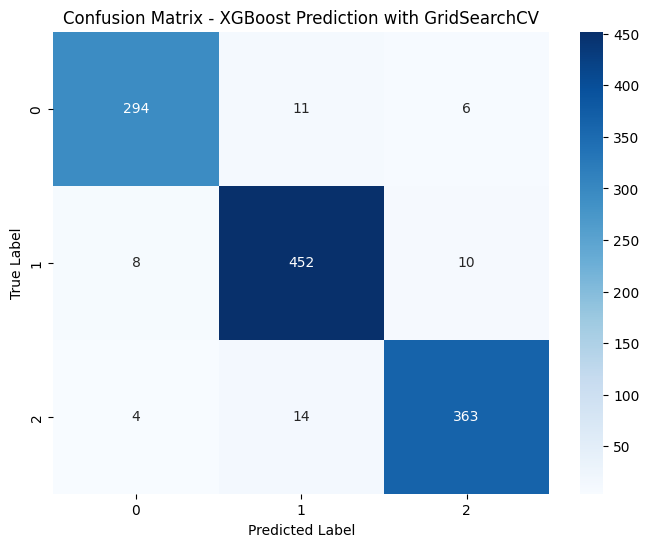

In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

clustered_df = pd.read_csv('output/clustered_data.csv')

# Step 1: Prepare data
X = clustered_df.drop(columns=['Cluster'])
y = clustered_df['Cluster']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Define the model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Step 4: Set up Grid Search Parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Step 5: Cross-Validation Strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 6: Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Step 7: Best Model
best_model = grid_search.best_estimator_
classification_model_best_params = grid_search.best_params_
print("Best Parameters Found:", grid_search.best_params_)

# Step 8: Predict
y_pred = best_model.predict(X_test)

# Step 9: Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGBoost Prediction with GridSearchCV')
plt.show()


#### 3.3.2 Building the Stacking Model

In [18]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import seaborn as sns
import matplotlib.pyplot as plt


In [19]:
# Separate features and labels
X = clustered_df[clustered_df['Cluster']==2].drop(columns=['Bankrupt?'])  # Replace 'Bankrupt?' with your target column
y = clustered_df[clustered_df['Cluster']==2]['Bankrupt?']


Tuning DT...
Best params for DT: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_split': 2}
Best CV Recall: 0.6398
------------------------------------------------------------
Tuning KNN...
Best params for KNN: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'uniform'}
Best CV Recall: 0.1775
------------------------------------------------------------
Tuning RF...
Best params for RF: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best CV Recall: 0.5660
------------------------------------------------------------
Tuning XGB...


c:\Users\aadit\Anaconda\envs\AaHB_CS556B_Env\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:40:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params for XGB: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 3}
Best CV Recall: 0.3685
------------------------------------------------------------


c:\Users\aadit\Anaconda\envs\AaHB_CS556B_Env\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Classification Report for Stacked Model:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       345
           1       0.44      0.46      0.45        37

    accuracy                           0.89       382
   macro avg       0.69      0.70      0.69       382
weighted avg       0.89      0.89      0.89       382



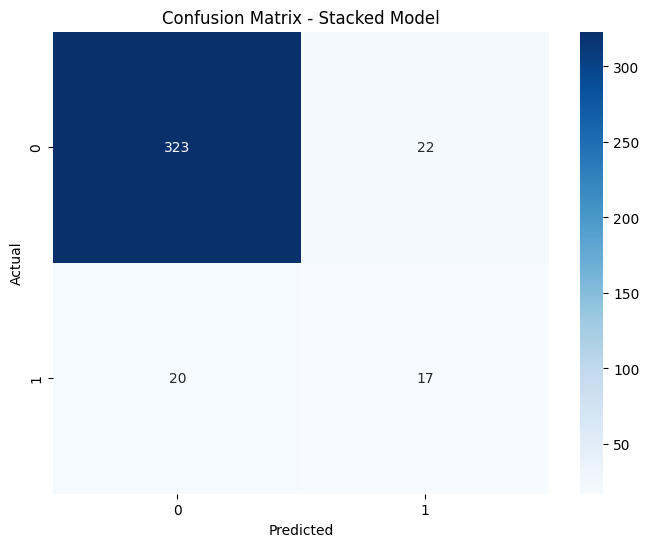

In [20]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# 1. Define feature matrix X and target vector y
# X = <your feature matrix>
# y = <your labels>

# 2. Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 3. Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Define hyperparameter grids
param_grid_dt = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}

param_grid_knn = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'scale_pos_weight': [1, 2, 3]
}

# 5. Initialize models
models = {
    'dt': (DecisionTreeClassifier(random_state=42), param_grid_dt),
    'knn': (make_pipeline(StandardScaler(), KNeighborsClassifier()), param_grid_knn),
    'rf': (RandomForestClassifier(random_state=42), param_grid_rf),
    'xgb': (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid_xgb)
}

# 6. Grid Search to find best base estimators
best_estimators = {}

for name, (model, param_grid) in models.items():
    print(f"Tuning {name.upper()}...")
    gs = GridSearchCV(model, param_grid, cv=cv_strategy, n_jobs=-1, scoring='recall')
    gs.fit(X_train, y_train)
    best_estimators[name] = gs.best_estimator_
    print(f"Best params for {name.upper()}: {gs.best_params_}")
    print(f"Best CV Recall: {gs.best_score_:.4f}")
    print("-" * 60)

# 7. Apply SMOTE to address class imbalance
smote = SMOTE(sampling_strategy='minority', random_state=42,k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 8. Build Stacking Classifier
stack_model = StackingClassifier(
    estimators=[(name, model) for name, model in best_estimators.items()],
    final_estimator=LogisticRegression(class_weight='balanced', random_state=42),
    cv=cv_strategy,
    n_jobs=-1,
    passthrough=False  # Turned off for safety against overfitting
)

# 9. Train Stacking Classifier on resampled data
stack_model.fit(X_train_resampled, y_train_resampled)

# 10. Evaluate on untouched test set
y_pred = stack_model.predict(X_test)

print("\nClassification Report for Stacked Model:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Stacked Model')
plt.show()


In [21]:
meta_model = LogisticRegression(random_state=42)


In [22]:
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    passthrough=True,
    n_jobs=-1
)
stack_model.fit(X,y)

NameError: name 'base_models' is not defined

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(stack_model, X, y, cv=cv, method='predict')

acc = accuracy_score(y, y_pred)
cm = confusion_matrix(y, y_pred)

print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y, y_pred))

print("\nConfusion Matrix:")
print(cm)
